In [ ]:
import glob
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array,array_to_img

In [ ]:
os.chdir('/content/drive/MyDrive/demo/')

In [ ]:
path = '/content/drive/MyDrive/demo/images_filpkart'
path2 = '/content/drive/MyDrive/demo'

In [ ]:
# Load image
img_height = 224
img_width = 224
channel=3
batch_size = 16
train_data_gen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

In [ ]:
training_data = train_data_gen.flow_from_directory(
    '/content/drive/MyDrive/demo',
    target_size = (img_height,img_width),
    color_mode = 'rgb',
    class_mode = 'input',
    subset = 'training',
    batch_size=batch_size,
    shuffle=True
)

Found 14704 images belonging to 2 classes.


In [ ]:
validation_data = train_data_gen.flow_from_directory(
    '/content/drive/MyDrive/demo',
    target_size = (img_height,img_width),
    color_mode = 'rgb',
    class_mode = 'input',
    subset = 'validation',
    batch_size=batch_size,
    shuffle=False
)

Found 3675 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.layers import Conv2D, Dense,MaxPool2D,BatchNormalization, Flatten,Conv2DTranspose,Input,Activation,Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import pandas as pd
# Autoencoder Model Architectures 
# Encoder
input = Input(shape=(img_height,img_width,channel))
encoder = Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer='glorot_uniform')(input)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer='glorot_uniform')(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer='glorot_uniform')(input)
encoder = BatchNormalization(axis=-1)(encoder)

encoder_shape = K.int_shape(encoder)
encoder = Flatten()(encoder)
# Latent Space :
latent_space = Dense(16,name='latent_space')(encoder)

# Decoder 
decoder = Dense(np.prod(encoder_shape[1:]))(latent_space)
decoder = Reshape((encoder_shape[1], encoder_shape[2], encoder_shape[3]))(decoder)

decoder = Conv2DTranspose(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer='glorot_uniform')(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer='glorot_uniform')(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer='glorot_uniform')(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

output = Conv2DTranspose(filters=3,kernel_size=(3,3),padding='same',activation='sigmoid',name='output')(decoder)


# Model Creation :
auto_encoder = Model(input,output,name='autoencoder')
auto_encoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_15 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
dropout_13 (Dropout)         (None, 224, 224, 64)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3211264)           0         
_________________________________________________________________
latent_space (Dense)         (None, 16)                51380240  
_________________________________________________________________
dense_2 (Dense)              (None, 3211264)           

In [ ]:
auto_encoder.compile(
    loss='mse',
    optimizer='adam',
)

In [ ]:
import time
start = time.time()
hist = auto_encoder.fit_generator(
    training_data,
    steps_per_epoch=training_data.n // batch_size ,
    epochs=100,
    validation_data=validation_data,
    validation_steps=validation_data.n // batch_size ,
    callbacks = [ModelCheckpoint('models/image_autoencoder_3.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)]
)

end = time.time()
print(end - start)

In [ ]:
auto_encoder.save('aotoencoder.h5')

In [ ]:
from tensorflow.keras.models import Model,load_model

In [ ]:
model =  load_model('/content/drive/MyDrive/demo/models/image_autoencoder_2.h5')

In [ ]:
def predict(image_dir,autoencoder):
  img_ = load_img(image_dir,target_size=(224,224))
  img = img_to_array(img_)
  img = np.expand_dims(img,axis=0)
  img = img/255.0
  pred = autoencoder.predict(img)
  pred = pred*155.0
  pred = np.reshape(pred,(224,224,3))
  pred = array_to_img(pred)
  return img_ , pred

In [ ]:
im_path = '/content/drive/MyDrive/demo/images_filpkart/fffe208fe08b938e4eda78727a99111d.jpg'
im , p = predict(im_path,model)

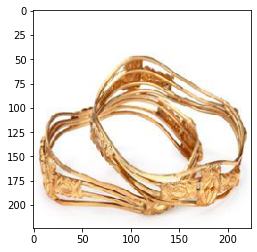

In [ ]:
plt.imshow(im)

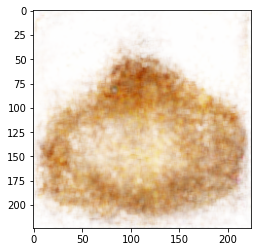

In [ ]:
plt.imshow(p)

In [ ]:
im_path2 = '/content/drive/MyDrive/demo/images_filpkart/ffb5009c96e81b6a3148345f7b54e2df.jpg'
src , pred = predict(im_path2,model)

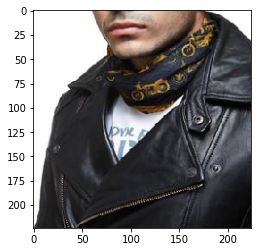

In [ ]:
plt.show(src)

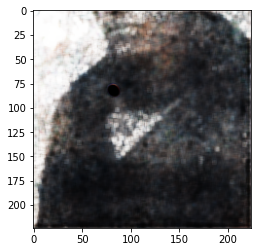

In [ ]:
plt.show(pred)